## Urban Heat Island (UHI) Model Training Notebook

### Data Sources
- **Training Data:** This dataset consists of traverse points across the Bronx and Manhattan. Each record includes longitude, latitude, a timestamp, and the UHI index.
- **Building Footprint Data:** This spatial dataset contains polygon geometries outlining building boundaries in NYC. It provides critical context on urban density and structure, which are important factors influencing the UHI effect.
- **Sentinel-2 Satellite Data:** This imagery supplies spectral data that we use to derive predictors.


### Overview

In this notebook, a baseline workflow that integrates the training data, building footprints, and Sentinel-2 imagery to build a model for predicting the UHI index.

1. **Data Preparation and Preprocessing:**
   - **Training Data:** Load traverse points with UHI index measurements.
   - **Building Footprint Data:** Incorporate detailed building geometries and extract features such as building count and total building area within multiple buffer zones (e.g., 100m, 500m, 1000m).
   - **Sentinel-2 Data:** Process spectral bands and compute indices. 

2. **Feature Engineering:**
   - Combine building-related features with spectral predictors derived from Sentinel-2 data.
   - Prepare a unified feature set for model training.

3. **Model Training and Evaluation:**
   - Develop a model (e.g., using a Random Forest algorithm) to predict the UHI index.
   - Evaluate model performance using appropriate metrics and refine the feature set accordingly.

4. **Validation Overview:**
   - **Validation Dataset:** This dataset contains 1040 records of validation points with longitude, latitude. Unlike the training data, the UHI Index is not provided here. The purpose of the validation dataset is to test the predictive performance of model on unseen data.
   - The validation dataset includes:
     - **Geographical Coordinates** Longitude and latitude values.
     - **Missing UHI Index:** The target variable (UHI Index) is not available, making it ideal for evaluating the model’s predictive capabilities.



## Load In Dependencies

In [32]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Multi-dimensional arrays and datasets
import xarray as xr

# Geospatial raster data handling
import rioxarray as rxr

# Geospatial data analysis
import geopandas as gpd

# Geospatial operations
import rasterio
from rasterio import windows  
from rasterio import features  
from rasterio import warp
from rasterio.warp import transform_bounds 
from rasterio.windows import from_bounds 

# Image Processing
from PIL import Image

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_validate

# Planetary Computer Tools
import pystac_client
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo

# Others
import os
from tqdm import tqdm

## Loading datasets

In [33]:
# Load the training and building data for both training and validation data
training_df = pd.read_csv('Training_data.csv')
print("Training data loaded successfully with shape:", training_df.shape)

building_df = pd.read_csv('training_building_output.csv')
print("Training building output loaded successfully with shape:", building_df.shape)

validation_df = pd.read_csv('Submission_template.csv')
print("Validation data loaded successfully with shape:", validation_df.shape)

validation_building_df = pd.read_csv('validation_building_output.csv')
print("Validation building output loaded successfully with shape:", validation_building_df.shape)


Training data loaded successfully with shape: (11229, 4)
Training building output loaded successfully with shape: (11229, 11)
Validation data loaded successfully with shape: (1040, 3)
Validation building output loaded successfully with shape: (1040, 10)


#### training data

In [34]:
training_df.head()

,Longitude,Latitude,datetime,UHI Index
0,-73.909167,40.813107,24-07-2021 15:53,1.030289
1,-73.909187,40.813045,24-07-2021 15:53,1.030289
2,-73.909215,40.812978,24-07-2021 15:53,1.023798
3,-73.909242,40.812908,24-07-2021 15:53,1.023798
4,-73.909257,40.812845,24-07-2021 15:53,1.021634


In [35]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11229 entries, 0 to 11228
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Longitude  11229 non-null  float64
 1   Latitude   11229 non-null  float64
 2   datetime   11229 non-null  object 
 3   UHI Index  11229 non-null  float64
dtypes: float64(3), object(1)
memory usage: 351.0+ KB


In [36]:
# Convert 'datetime' column to datetime format
training_df['datetime'] = pd.to_datetime(training_df['datetime'], errors='coerce')

print("\nTraining Data Info:")
training_df.info()


Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11229 entries, 0 to 11228
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Longitude  11229 non-null  float64       
 1   Latitude   11229 non-null  float64       
 2   datetime   11229 non-null  datetime64[ns]
 3   UHI Index  11229 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 351.0 KB


In [37]:
# Check for missing values
print("\nMissing values in training data:\n", training_df.isnull().sum())


Missing values in training data:
 Longitude    0
Latitude     0
datetime     0
UHI Index    0
dtype: int64


In [38]:
building_df.head()

,Longitude,Latitude,datetime,UHI Index,geometry,building_count_100m,total_building_area_100m,building_count_500m,total_building_area_500m,building_count_1000m,total_building_area_1000m
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,POINT (592000.2226016461 4518582.907902403),9,22021.913865,173,238056.221827,722,990085.767678
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,POINT (591998.6209797623 4518576.040994349),10,23529.583653,174,242292.709280,720,994295.954553
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,POINT (591996.3237008754 4518568.6102995025),9,21067.543693,177,247121.188061,718,990577.919305
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,POINT (591994.1710234808 4518560.811688332),8,19166.747335,175,246855.836543,716,990771.620217
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,POINT (591992.9933896236 4518553.765754995),8,19166.747335,173,245431.994656,709,985447.972126


In [39]:
building_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11229 entries, 0 to 11228
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Longitude                  11229 non-null  float64
 1   Latitude                   11229 non-null  float64
 2   datetime                   11229 non-null  object 
 3   UHI Index                  11229 non-null  float64
 4   geometry                   11229 non-null  object 
 5   building_count_100m        11229 non-null  int64  
 6   total_building_area_100m   11229 non-null  float64
 7   building_count_500m        11229 non-null  int64  
 8   total_building_area_500m   11229 non-null  float64
 9   building_count_1000m       11229 non-null  int64  
 10  total_building_area_1000m  11229 non-null  float64
dtypes: float64(6), int64(3), object(2)
memory usage: 965.1+ KB


In [40]:
# Convert 'datetime' column to datetime format
building_df['datetime'] = pd.to_datetime(building_df['datetime'], errors='coerce')

print("\nBuilding Data Info:")
building_df.info()


Building Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11229 entries, 0 to 11228
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Longitude                  11229 non-null  float64       
 1   Latitude                   11229 non-null  float64       
 2   datetime                   11229 non-null  datetime64[ns]
 3   UHI Index                  11229 non-null  float64       
 4   geometry                   11229 non-null  object        
 5   building_count_100m        11229 non-null  int64         
 6   total_building_area_100m   11229 non-null  float64       
 7   building_count_500m        11229 non-null  int64         
 8   total_building_area_500m   11229 non-null  float64       
 9   building_count_1000m       11229 non-null  int64         
 10  total_building_area_1000m  11229 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(3), ob

In [41]:
# Drop 'geometry' column from building data
building_df = building_df.drop(['geometry'], axis=1)
print("\nTraining Building Data (after dropping 'geometry'):")
print(building_df.info())


Training Building Data (after dropping 'geometry'):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11229 entries, 0 to 11228
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Longitude                  11229 non-null  float64       
 1   Latitude                   11229 non-null  float64       
 2   datetime                   11229 non-null  datetime64[ns]
 3   UHI Index                  11229 non-null  float64       
 4   building_count_100m        11229 non-null  int64         
 5   total_building_area_100m   11229 non-null  float64       
 6   building_count_500m        11229 non-null  int64         
 7   total_building_area_500m   11229 non-null  float64       
 8   building_count_1000m       11229 non-null  int64         
 9   total_building_area_1000m  11229 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(3)
memory usage: 877.4 KB
None


#### validation data

In [42]:
validation_df.head()

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,NaN
1,-73.971928,40.788875,NaN
2,-73.967080,40.789080,NaN
3,-73.972550,40.789082,NaN
4,-73.969697,40.787953,NaN


In [43]:
validation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040 entries, 0 to 1039
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Longitude  1040 non-null   float64
 1   Latitude   1040 non-null   float64
 2   UHI Index  0 non-null      float64
dtypes: float64(3)
memory usage: 24.5 KB


In [44]:
validation_building_df.head()

,Longitude,Latitude,UHI Index,geometry,building_count_100m,total_building_area_100m,building_count_500m,total_building_area_500m,building_count_1000m,total_building_area_1000m
0,-73.971665,40.788763,NaN,POINT (586760.7604737612 4515816.875194865),10,30704.263610,94,434537.078135,235,956067.936204
1,-73.971928,40.788875,NaN,POINT (586738.3976096781 4515829.010973928),9,24891.711996,101,469133.965195,237,967377.849328
2,-73.967080,40.789080,NaN,POINT (587147.1897002351 4515856.574399165),3,32298.190406,61,265037.151345,241,981122.105508
3,-73.972550,40.789082,NaN,POINT (586685.677691767 4515851.338306113),8,23026.854977,105,488182.982636,237,986609.310192
4,-73.969697,40.787953,NaN,POINT (586927.8877734912 4515728.907886715),5,53357.162819,66,331546.180958,228,976210.864820


In [45]:
# Check for missing values
print("\nMissing values in validation data:\n", validation_df.isnull().sum())


Missing values in validation data:
 Longitude       0
Latitude        0
UHI Index    1040
dtype: int64


In [46]:
validation_building_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040 entries, 0 to 1039
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Longitude                  1040 non-null   float64
 1   Latitude                   1040 non-null   float64
 2   UHI Index                  0 non-null      float64
 3   geometry                   1040 non-null   object 
 4   building_count_100m        1040 non-null   int64  
 5   total_building_area_100m   1040 non-null   float64
 6   building_count_500m        1040 non-null   int64  
 7   total_building_area_500m   1040 non-null   float64
 8   building_count_1000m       1040 non-null   int64  
 9   total_building_area_1000m  1040 non-null   float64
dtypes: float64(6), int64(3), object(1)
memory usage: 81.4+ KB


In [47]:
# Check for missing values
print("\nMissing values in validation building data:\n", validation_building_df.isnull().sum())


Missing values in validation building data:
 Longitude                       0
Latitude                        0
UHI Index                    1040
geometry                        0
building_count_100m             0
total_building_area_100m        0
building_count_500m             0
total_building_area_500m        0
building_count_1000m            0
total_building_area_1000m       0
dtype: int64


In [48]:
# Drop 'geometry' column from building data
validation_building_df = validation_building_df.drop(['geometry'], axis=1)
print("\nValidation Building Data (after dropping 'geometry'):")
print(validation_building_df.info())


Validation Building Data (after dropping 'geometry'):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040 entries, 0 to 1039
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Longitude                  1040 non-null   float64
 1   Latitude                   1040 non-null   float64
 2   UHI Index                  0 non-null      float64
 3   building_count_100m        1040 non-null   int64  
 4   total_building_area_100m   1040 non-null   float64
 5   building_count_500m        1040 non-null   int64  
 6   total_building_area_500m   1040 non-null   float64
 7   building_count_1000m       1040 non-null   int64  
 8   total_building_area_1000m  1040 non-null   float64
dtypes: float64(6), int64(3)
memory usage: 73.2 KB
None


In [49]:
# Set the threshold for a 500m buffer.
# assume that if an area has 75 or more buildings within a 500m radius, it can be classified as 'urban'
urban_threshold_500m = 75  

# Apply a lambda function to the 'building_count_500m' column to classify each area:
# If the building count is greater than or equal to the threshold, label it as 'urban', otherwise label it as 'rural'
building_df['area_type'] = building_df['building_count_500m'].apply(
    lambda x: 'urban' if x >= urban_threshold_500m else 'rural'
)

# Print the first few rows of the DataFrame
print(building_df.head())


   Longitude   Latitude            datetime  UHI Index  building_count_100m  \
0 -73.909167  40.813107 2021-07-24 15:53:00   1.030289                    9   
1 -73.909187  40.813045 2021-07-24 15:53:00   1.030289                   10   
2 -73.909215  40.812978 2021-07-24 15:53:00   1.023798                    9   
3 -73.909242  40.812908 2021-07-24 15:53:00   1.023798                    8   
4 -73.909257  40.812845 2021-07-24 15:53:00   1.021634                    8   

   total_building_area_100m  building_count_500m  total_building_area_500m  \
0              22021.913865                  173             238056.221827   
1              23529.583653                  174             242292.709280   
2              21067.543693                  177             247121.188061   
3              19166.747335                  175             246855.836543   
4              19166.747335                  173             245431.994656   

   building_count_1000m  total_building_area_1000m area_

In [50]:
# Set the threshold for a 500m buffer.
# If an area has 75 or more buildings within a 500m radius, it is classified as 'urban'
urban_threshold_500m = 75  

# Apply a lambda function to the 'building_count_500m' column of the validation building data:
# If the building count is greater than or equal to the threshold, label it as 'urban', otherwise label it as 'rural'
validation_building_df['area_type'] = validation_building_df['building_count_500m'].apply(
    lambda x: 'urban' if x >= urban_threshold_500m else 'rural'
)

# Print the first few rows of the validation building DataFrame to verify the new 'area_type' classification
print(validation_building_df.head())


   Longitude   Latitude  UHI Index  building_count_100m  \
0 -73.971665  40.788763        NaN                   10   
1 -73.971928  40.788875        NaN                    9   
2 -73.967080  40.789080        NaN                    3   
3 -73.972550  40.789082        NaN                    8   
4 -73.969697  40.787953        NaN                    5   

   total_building_area_100m  building_count_500m  total_building_area_500m  \
0              30704.263610                   94             434537.078135   
1              24891.711996                  101             469133.965195   
2              32298.190406                   61             265037.151345   
3              23026.854977                  105             488182.982636   
4              53357.162819                   66             331546.180958   

   building_count_1000m  total_building_area_1000m area_type  
0                   235              956067.936204     urban  
1                   237              967377.849328

In [51]:
# One-hot encode the 'area_type' column in the training building dataset.
# This creates new columns (e.g., area_rural, area_urban) with binary indicators.
area_dummies = pd.get_dummies(building_df['area_type'], prefix='area')

# Concatenate the new one-hot encoded columns back into the original training building DataFrame.
building_df = pd.concat([building_df, area_dummies], axis=1)

# Print the first few rows to verify the new columns were added correctly.
print("Training Building Data after One-Hot Encoding:")
print(building_df.head())

Training Building Data after One-Hot Encoding:
   Longitude   Latitude            datetime  UHI Index  building_count_100m  \
0 -73.909167  40.813107 2021-07-24 15:53:00   1.030289                    9   
1 -73.909187  40.813045 2021-07-24 15:53:00   1.030289                   10   
2 -73.909215  40.812978 2021-07-24 15:53:00   1.023798                    9   
3 -73.909242  40.812908 2021-07-24 15:53:00   1.023798                    8   
4 -73.909257  40.812845 2021-07-24 15:53:00   1.021634                    8   

   total_building_area_100m  building_count_500m  total_building_area_500m  \
0              22021.913865                  173             238056.221827   
1              23529.583653                  174             242292.709280   
2              21067.543693                  177             247121.188061   
3              19166.747335                  175             246855.836543   
4              19166.747335                  173             245431.994656   

   buildi

In [52]:
# One-hot encode the 'area_type' column in the validation building dataset.
area_dummies_val = pd.get_dummies(validation_building_df['area_type'], prefix='area')

# Concatenate the new one-hot encoded columns back into the original validation building DataFrame.
validation_building_df = pd.concat([validation_building_df, area_dummies_val], axis=1)

# Print the first few rows to verify the new columns were added correctly.
print("Validation Building Data after One-Hot Encoding:")
print(validation_building_df.head())

Validation Building Data after One-Hot Encoding:
   Longitude   Latitude  UHI Index  building_count_100m  \
0 -73.971665  40.788763        NaN                   10   
1 -73.971928  40.788875        NaN                    9   
2 -73.967080  40.789080        NaN                    3   
3 -73.972550  40.789082        NaN                    8   
4 -73.969697  40.787953        NaN                    5   

   total_building_area_100m  building_count_500m  total_building_area_500m  \
0              30704.263610                   94             434537.078135   
1              24891.711996                  101             469133.965195   
2              32298.190406                   61             265037.151345   
3              23026.854977                  105             488182.982636   
4              53357.162819                   66             331546.180958   

   building_count_1000m  total_building_area_1000m area_type  area_rural  \
0                   235              956067.936204 

In [53]:
# Count duplicate rows in the training building DataFrame
building_df.duplicated().sum()

np.int64(0)

In [54]:
# Count duplicate rows in the validation building DataFrame
validation_building_df.duplicated().sum()

np.int64(0)

In [55]:
%who DataFrame


area_dummies	 area_dummies_val	 building_df	 ground_df	 ground_validation_df	 training_df	 validation_building_df	 validation_df	 


#### Merging Data

##### Merge for Training Data

In [56]:
# Merge 'training_df' with 'building_df' on the common keys: 'Longitude', 'Latitude', and 'datetime'.
# drop the 'UHI Index' column from 'building_df' to prevent duplicate data, it's already present in 'training_df'.
ground_df = pd.merge(
    training_df,
    building_df.drop(columns=['UHI Index']),
    on=['Longitude', 'Latitude', 'datetime'],
    how='left'
)

# Display the first few rows of the merged training DataFrame.
print("Merged Training Data:")
print(ground_df.head())

Merged Training Data:
   Longitude   Latitude            datetime  UHI Index  building_count_100m  \
0 -73.909167  40.813107 2021-07-24 15:53:00   1.030289                    9   
1 -73.909187  40.813045 2021-07-24 15:53:00   1.030289                   10   
2 -73.909215  40.812978 2021-07-24 15:53:00   1.023798                    9   
3 -73.909242  40.812908 2021-07-24 15:53:00   1.023798                    8   
4 -73.909257  40.812845 2021-07-24 15:53:00   1.021634                    8   

   total_building_area_100m  building_count_500m  total_building_area_500m  \
0              22021.913865                  173             238056.221827   
1              23529.583653                  174             242292.709280   
2              21067.543693                  177             247121.188061   
3              19166.747335                  175             246855.836543   
4              19166.747335                  173             245431.994656   

   building_count_1000m  total_bui

In [57]:
# Print the structure and information about the merged training DataFrame.
ground_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11229 entries, 0 to 11228
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Longitude                  11229 non-null  float64       
 1   Latitude                   11229 non-null  float64       
 2   datetime                   11229 non-null  datetime64[ns]
 3   UHI Index                  11229 non-null  float64       
 4   building_count_100m        11229 non-null  int64         
 5   total_building_area_100m   11229 non-null  float64       
 6   building_count_500m        11229 non-null  int64         
 7   total_building_area_500m   11229 non-null  float64       
 8   building_count_1000m       11229 non-null  int64         
 9   total_building_area_1000m  11229 non-null  float64       
 10  area_type                  11229 non-null  object        
 11  area_rural                 11229 non-null  bool          
 12  area

##### Merge for Validation Data

In [58]:
# Merge 'validation_df' with 'validation_building_df' on the common keys: 'Longitude' and 'Latitude'.
# Similarly, drop the 'UHI Index' column from 'validation_building_df' to avoid duplicating this information.
ground_validation_df = pd.merge(
    validation_df,
    validation_building_df.drop(columns=['UHI Index']),
    on=['Longitude', 'Latitude'],
    how='left'
)

# Display the first few rows of the merged validation DataFrame.
print("Merged Validation Data:")
print(ground_validation_df.head())

Merged Validation Data:
   Longitude   Latitude  UHI Index  building_count_100m  \
0 -73.971665  40.788763        NaN                   10   
1 -73.971928  40.788875        NaN                    9   
2 -73.967080  40.789080        NaN                    3   
3 -73.972550  40.789082        NaN                    8   
4 -73.969697  40.787953        NaN                    5   

   total_building_area_100m  building_count_500m  total_building_area_500m  \
0              30704.263610                   94             434537.078135   
1              24891.711996                  101             469133.965195   
2              32298.190406                   61             265037.151345   
3              23026.854977                  105             488182.982636   
4              53357.162819                   66             331546.180958   

   building_count_1000m  total_building_area_1000m area_type  area_rural  \
0                   235              956067.936204     urban       False   


In [59]:
# Print the structure and information about the merged training DataFrame.
ground_validation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040 entries, 0 to 1039
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Longitude                  1040 non-null   float64
 1   Latitude                   1040 non-null   float64
 2   UHI Index                  0 non-null      float64
 3   building_count_100m        1040 non-null   int64  
 4   total_building_area_100m   1040 non-null   float64
 5   building_count_500m        1040 non-null   int64  
 6   total_building_area_500m   1040 non-null   float64
 7   building_count_1000m       1040 non-null   int64  
 8   total_building_area_1000m  1040 non-null   float64
 9   area_type                  1040 non-null   object 
 10  area_rural                 1040 non-null   bool   
 11  area_urban                 1040 non-null   bool   
dtypes: bool(2), float64(6), int64(3), object(1)
memory usage: 83.4+ KB


### Loading Sentinel-2 Satellite Data from GeoTIFF file

Loading a GeoTIFF file created in the Sentinel2_Notebook. The file, Sentinel2.tiff, represents a single day (24th July 2021) and contains data for spectral bands. We will extract band values at the geo-locations specified in our training dataset and derive various features for model training. Finally, we will visualize these bands to better understand the underlying data.

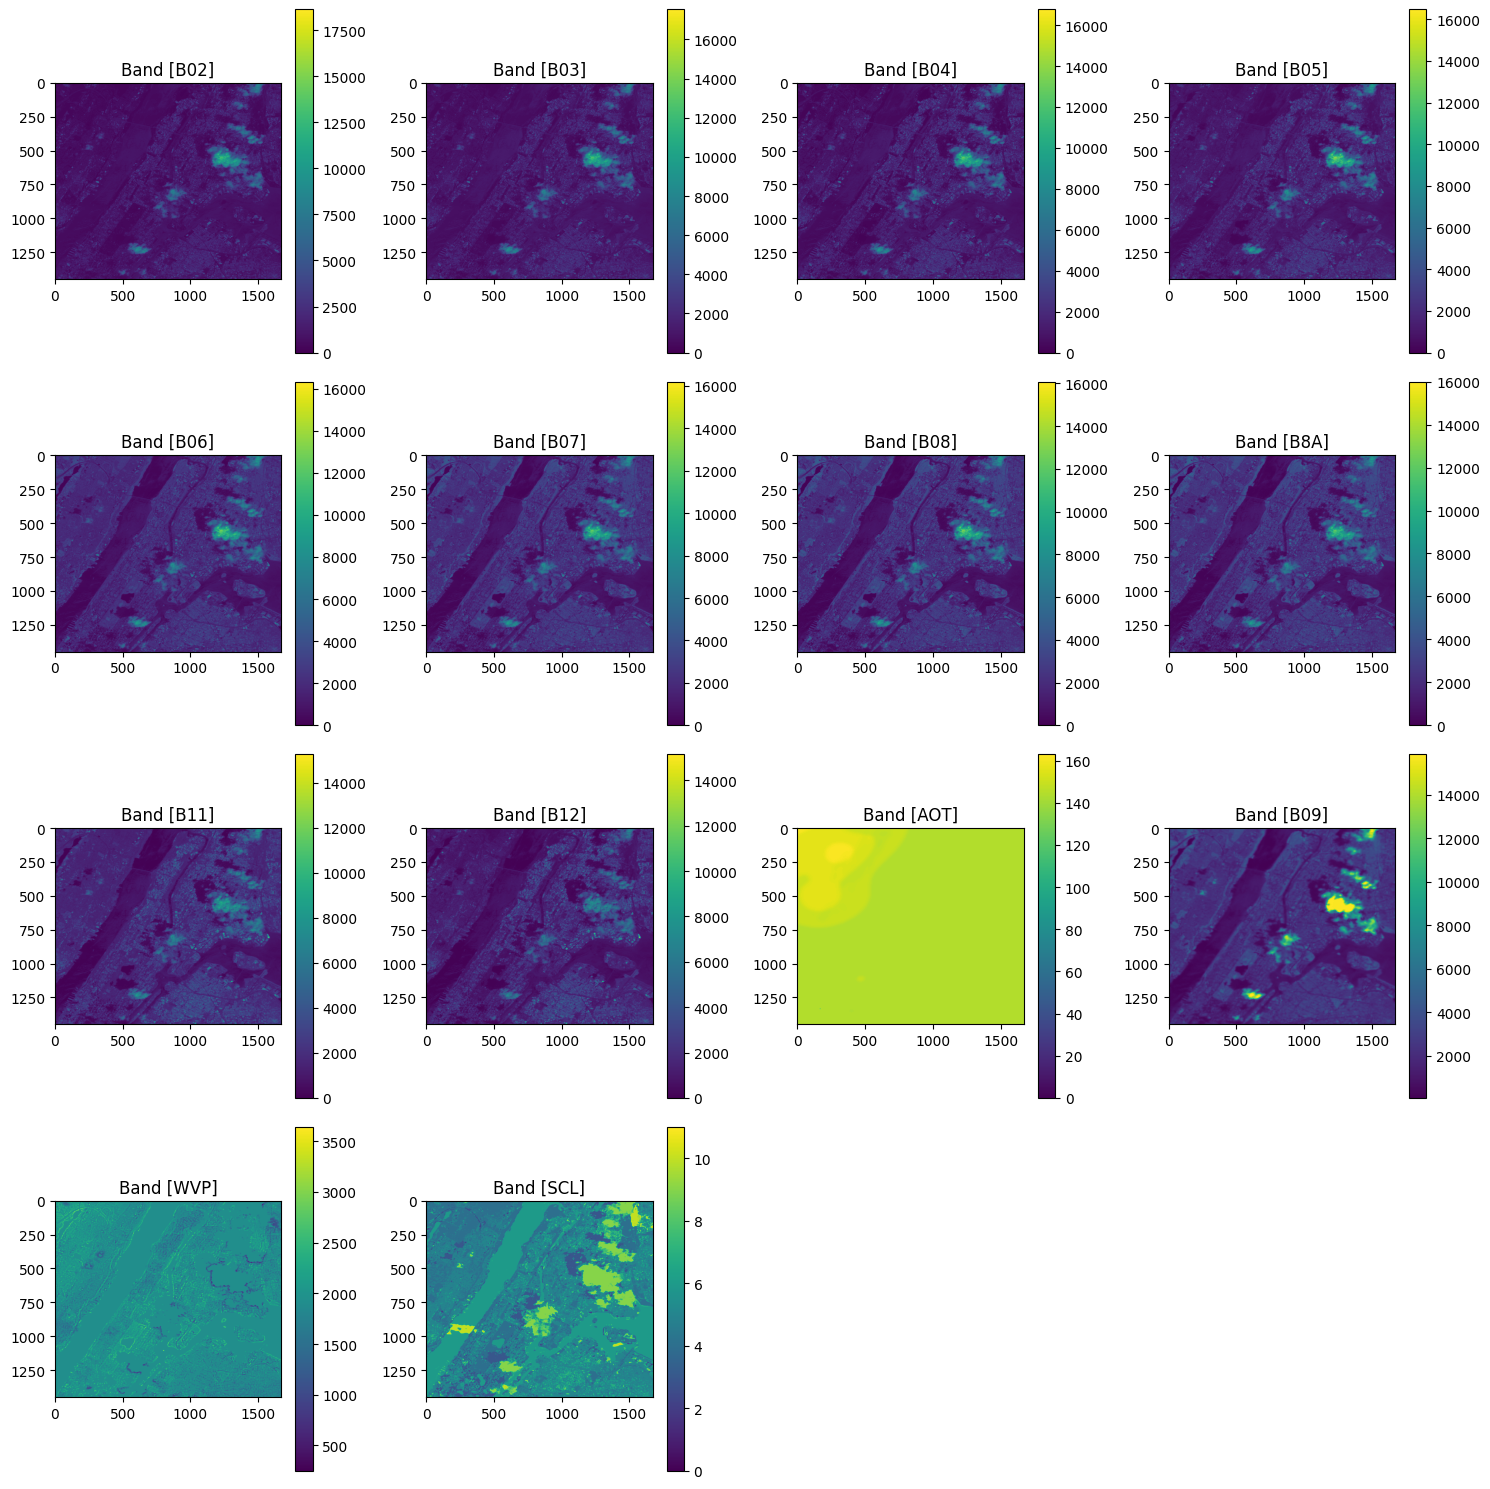

In [60]:
# Path to the GeoTIFF file
tiff_path = "Sentinel2.tiff"

# Open the GeoTIFF file and read all 14 bands
with rasterio.open(tiff_path) as src:
    bands = [src.read(i) for i in range(1, 15)]  # Read bands 1 to 14

# Define band names
band_names = ["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12", "AOT", "B09", "WVP", "SCL"]

# Plot the bands in a 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(15, 15))
axes = axes.flatten()

for i, (band, name) in enumerate(zip(bands, band_names)):
    im = axes[i].imshow(band, cmap='viridis')
    axes[i].set_title(f'Band [{name}]')
    fig.colorbar(im, ax=axes[i])

# Hide any unused subplots
for j in range(len(bands), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [61]:
def map_satellite_data(tiff_path, csv_path):
    # Load the GeoTIFF data using rioxarray.
    data = rxr.open_rasterio(tiff_path)
    # Get the Coordinate Reference System (CRS) of the GeoTIFF.
    tiff_crs = data.rio.crs

    # Read the CSV file containing geo-locations using pandas.
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # Convert lat/long coordinates to the GeoTIFF's CRS.
    # EPSG:4326 is the standard lat/long CRS.
    proj_wgs84 = Proj(init='epsg:4326')
    proj_tiff = Proj(tiff_crs)
    transformer = Transformer.from_proj(proj_wgs84, proj_tiff)

    # Initialize a dictionary to store band values.
    # This creates keys for bands B01 to B12 with empty lists.
    band_values = {f'B{i:02}': [] for i in range(1, 13)}
    # Add additional bands/indices (B8A, AOT, WVP, SCL) with empty lists.
    band_values.update({'B8A': [], 'AOT': [], 'WVP': [], 'SCL': []})

    # Iterate over each latitude and longitude pair.
    # The tqdm function displays a progress bar for the loop.
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
        # For each band, extract the pixel value closest to the given location.
        for i, band_name in enumerate(band_values.keys(), start=1):
            band_value = data.sel(x=lon, y=lat, band=i, method="nearest").values
            band_values[band_name].append(band_value)

    # Create a DataFrame from the dictionary of band values.
    # This DataFrame will hold the extracted satellite data for each geo-location.
    df_result = pd.DataFrame(band_values)
    return df_result


In [62]:
# Mapping satellite data with training data.
# The function map_satellite_data extracts satellite band values based on geo-locations provided in the CSV.
final_data = map_satellite_data(
    'Sentinel2.tiff', 
    'Training_data.csv'
)
print("Training data mapping complete:")
print(final_data.info())

Mapping values: 100%|████████████████████████████████████████████████████████████| 11229/11229 [04:12<00:00, 44.51it/s]

Training data mapping complete:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11229 entries, 0 to 11228
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   B01     11229 non-null  object
 1   B02     11229 non-null  object
 2   B03     11229 non-null  object
 3   B04     11229 non-null  object
 4   B05     11229 non-null  object
 5   B06     11229 non-null  object
 6   B07     11229 non-null  object
 7   B08     11229 non-null  object
 8   B09     11229 non-null  object
 9   B10     11229 non-null  object
 10  B11     11229 non-null  object
 11  B12     11229 non-null  object
 12  B8A     11229 non-null  object
 13  AOT     11229 non-null  object
 14  WVP     11229 non-null  object
 15  SCL     11229 non-null  object
dtypes: object(16)
memory usage: 1.4+ MB
None


In [63]:
# Mapping satellite data with validation data.
# The same function is used to extract band values for the validation dataset.
final_validation_data = map_satellite_data(
    'Sentinel2.tiff', 
    'Submission_template.csv'
)
print("Validation data mapping complete:")
print(final_validation_data.info())

Mapping values: 100%|██████████████████████████████████████████████████████████████| 1040/1040 [00:23<00:00, 44.29it/s]

Validation data mapping complete:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040 entries, 0 to 1039
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   B01     1040 non-null   object
 1   B02     1040 non-null   object
 2   B03     1040 non-null   object
 3   B04     1040 non-null   object
 4   B05     1040 non-null   object
 5   B06     1040 non-null   object
 6   B07     1040 non-null   object
 7   B08     1040 non-null   object
 8   B09     1040 non-null   object
 9   B10     1040 non-null   object
 10  B11     1040 non-null   object
 11  B12     1040 non-null   object
 12  B8A     1040 non-null   object
 13  AOT     1040 non-null   object
 14  WVP     1040 non-null   object
 15  SCL     1040 non-null   object
dtypes: object(16)
memory usage: 130.1+ KB
None


In [64]:
# Print the first few rows of the mapped training data.
print("Mapped training data:")
print(final_data.head())

# Print the first few rows of the mapped validation data.
print("\nMapped validation data:")
print(final_validation_data.head())


Mapped training data:
      B01     B02     B03     B04     B05     B06     B07     B08     B09  \
0  1042.0  1036.0  1036.0  1272.0  1502.0  1605.0  1906.0  1638.0  1487.0   
1  1042.0  1036.0  1036.0  1272.0  1502.0  1605.0  1906.0  1638.0  1487.0   
2   583.0   818.0   709.0  1054.0  1668.0  2097.0  2190.0  2149.0  1465.0   
3   581.0   733.0   657.0  1054.0  1668.0  2097.0  2182.0  2149.0  1465.0   
4   655.0   744.0   745.0  1021.0  1728.0  1943.0  2112.0  2056.0  1544.0   

      B10    B11     B12     B8A  AOT  WVP  SCL  
0  1265.0  144.0  2096.0  1924.0  5.0  5.0  5.0  
1  1265.0  144.0  2096.0  1924.0  5.0  5.0  5.0  
2   991.0  144.0  2096.0  2068.0  5.0  5.0  5.0  
3   991.0  144.0  2096.0  2068.0  5.0  5.0  5.0  
4  1134.0  144.0  2096.0  1924.0  5.0  5.0  5.0  

Mapped validation data:
      B01     B02     B03     B04     B05     B06     B07     B08     B09  \
0   459.0   617.0   432.0   984.0  2089.0  2405.0  2502.0  2552.0  1474.0   
1   562.0   731.0   647.0  1112.0  2

In [65]:
# List of spectral band columns to be used as float values
band_cols = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07',
             'B08', 'B09', 'B10', 'B11', 'B12', 'B8A']

# Convert spectral bands to float for precision in index calculations
for col in band_cols:
    final_data[col] = pd.to_numeric(final_data[col], errors='coerce').astype(float)

# Convert continuous measurement columns to float
for col in ['AOT', 'WVP']:
    final_data[col] = pd.to_numeric(final_data[col], errors='coerce').astype(float)

# convert to an integer type
final_data['SCL'] = pd.to_numeric(final_data['SCL'], errors='coerce').astype('Int64')

# Check the DataFrame info to confirm the changes
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11229 entries, 0 to 11228
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   B01     11229 non-null  float64
 1   B02     11229 non-null  float64
 2   B03     11229 non-null  float64
 3   B04     11229 non-null  float64
 4   B05     11229 non-null  float64
 5   B06     11229 non-null  float64
 6   B07     11229 non-null  float64
 7   B08     11229 non-null  float64
 8   B09     11229 non-null  float64
 9   B10     11229 non-null  float64
 10  B11     11229 non-null  float64
 11  B12     11229 non-null  float64
 12  B8A     11229 non-null  float64
 13  AOT     11229 non-null  float64
 14  WVP     11229 non-null  float64
 15  SCL     11229 non-null  Int64  
dtypes: Int64(1), float64(15)
memory usage: 1.4 MB


In [66]:
# List of spectral band columns to be used as float values
band_cols = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07',
             'B08', 'B09', 'B10', 'B11', 'B12', 'B8A']

# Convert spectral band columns to float for precision in index calculations
for col in band_cols:
    final_validation_data[col] = pd.to_numeric(final_validation_data[col], errors='coerce').astype(float)

# Convert continuous measurement columns (AOT and WVP) to float
for col in ['AOT', 'WVP']:
    final_validation_data[col] = pd.to_numeric(final_validation_data[col], errors='coerce').astype(float)

# Convert the Scene Classification (SCL)
final_validation_data['SCL'] = pd.to_numeric(final_validation_data['SCL'], errors='coerce').astype('Int64')

# Check the DataFrame info to confirm the changes
final_validation_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040 entries, 0 to 1039
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   B01     1040 non-null   float64
 1   B02     1040 non-null   float64
 2   B03     1040 non-null   float64
 3   B04     1040 non-null   float64
 4   B05     1040 non-null   float64
 5   B06     1040 non-null   float64
 6   B07     1040 non-null   float64
 7   B08     1040 non-null   float64
 8   B09     1040 non-null   float64
 9   B10     1040 non-null   float64
 10  B11     1040 non-null   float64
 11  B12     1040 non-null   float64
 12  B8A     1040 non-null   float64
 13  AOT     1040 non-null   float64
 14  WVP     1040 non-null   float64
 15  SCL     1040 non-null   Int64  
dtypes: Int64(1), float64(15)
memory usage: 131.1 KB


In [67]:
final_data.duplicated().sum()

np.int64(2868)

In [68]:
final_validation_data.duplicated().sum()

np.int64(28)

#### Calculating Different Indices for Training Data

In [69]:
# Calculate NDVI (Normalized Difference Vegetation Index)
final_data['NDVI'] = (final_data['B08'] - final_data['B04']) / (final_data['B08'] + final_data['B04'])
final_data['NDVI'] = final_data['NDVI'].replace([np.inf, -np.inf], np.nan)

# Calculate NDBI (Normalized Difference Built-up Index)
# NDBI highlights built-up areas using SWIR (B11) and NIR (B08)
final_data['NDBI'] = (final_data['B11'] - final_data['B08']) / (final_data['B11'] + final_data['B08'])
final_data['NDBI'] = final_data['NDBI'].replace([np.inf, -np.inf], np.nan)

# Calculate NDWI (Modified Normalized Difference Water Index)
# NDWI is often used to delineate water bodies, here using Green (B03) and SWIR (B11)
final_data['NDWI'] = (final_data['B03'] - final_data['B11']) / (final_data['B03'] + final_data['B11'])
final_data['NDWI'] = final_data['NDWI'].replace([np.inf, -np.inf], np.nan)

# Calculate NDMI (Normalized Difference Moisture Index)
# NDMI is useful for assessing vegetation water content, using NIR (B08) and SWIR (B11)
final_data['NDMI'] = (final_data['B08'] - final_data['B11']) / (final_data['B08'] + final_data['B11'])
final_data['NDMI'] = final_data['NDMI'].replace([np.inf, -np.inf], np.nan)

# Calculate EVI (Enhanced Vegetation Index)
# EVI improves sensitivity in high biomass regions by using the blue band (B02) along with B04 and B08
final_data['EVI'] = 2.5 * (final_data['B08'] - final_data['B04']) / (final_data['B08'] + 6 * final_data['B04'] - 7.5 * final_data['B02'] + 1)
final_data['EVI'] = final_data['EVI'].replace([np.inf, -np.inf], np.nan)


In [70]:
final_data.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B09,B10,...,B12,B8A,AOT,WVP,SCL,NDVI,NDBI,NDWI,NDMI,EVI
0,1042.0,1036.0,1036.0,1272.0,1502.0,1605.0,1906.0,1638.0,1487.0,1265.0,...,2096.0,1924.0,5.0,5.0,5,0.125773,-0.838384,0.755932,0.838384,0.609594
1,1042.0,1036.0,1036.0,1272.0,1502.0,1605.0,1906.0,1638.0,1487.0,1265.0,...,2096.0,1924.0,5.0,5.0,5,0.125773,-0.838384,0.755932,0.838384,0.609594
2,583.0,818.0,709.0,1054.0,1668.0,2097.0,2190.0,2149.0,1465.0,991.0,...,2096.0,2068.0,5.0,5.0,5,0.341867,-0.874400,0.662368,0.874400,1.170372
3,581.0,733.0,657.0,1054.0,1668.0,2097.0,2182.0,2149.0,1465.0,991.0,...,2096.0,2068.0,5.0,5.0,5,0.341867,-0.874400,0.640449,0.874400,0.919704
4,655.0,744.0,745.0,1021.0,1728.0,1943.0,2112.0,2056.0,1544.0,1134.0,...,2096.0,1924.0,5.0,5.0,5,0.336367,-0.869091,0.676040,0.869091,0.994045


#### Calculating Different Indices for Validation Data

In [71]:
# Calculate NDVI (Normalized Difference Vegetation Index) for validation data.
# NDVI = (NIR - Red) / (NIR + Red), using B08 (NIR) and B04 (Red)
final_validation_data['NDVI'] = (final_validation_data['B08'] - final_validation_data['B04']) / (final_validation_data['B08'] + final_validation_data['B04'])
# Replace infinite values with NaN.
final_validation_data['NDVI'] = final_validation_data['NDVI'].replace([np.inf, -np.inf], np.nan)

# Calculate NDBI (Normalized Difference Built-up Index) for validation data.
# NDBI highlights built-up areas using SWIR (B11) and NIR (B08)
final_validation_data['NDBI'] = (final_validation_data['B11'] - final_validation_data['B08']) / (final_validation_data['B11'] + final_validation_data['B08'])
final_validation_data['NDBI'] = final_validation_data['NDBI'].replace([np.inf, -np.inf], np.nan)

# Calculate NDWI (Modified Normalized Difference Water Index) for validation data.
# NDWI is used to delineate water bodies, here using Green (B03) and SWIR (B11)
final_validation_data['NDWI'] = (final_validation_data['B03'] - final_validation_data['B11']) / (final_validation_data['B03'] + final_validation_data['B11'])
final_validation_data['NDWI'] = final_validation_data['NDWI'].replace([np.inf, -np.inf], np.nan)

# Calculate NDMI (Normalized Difference Moisture Index) for validation data.
# NDMI assesses vegetation water content, using NIR (B08) and SWIR (B11)
final_validation_data['NDMI'] = (final_validation_data['B08'] - final_validation_data['B11']) / (final_validation_data['B08'] + final_validation_data['B11'])
final_validation_data['NDMI'] = final_validation_data['NDMI'].replace([np.inf, -np.inf], np.nan)

# Calculate EVI (Enhanced Vegetation Index) for validation data.
# EVI improves sensitivity in high biomass regions using Blue (B02), Red (B04), and NIR (B08)
final_validation_data['EVI'] = 2.5 * (final_validation_data['B08'] - final_validation_data['B04']) / (final_validation_data['B08'] + 6 * final_validation_data['B04'] - 7.5 * final_validation_data['B02'] + 1)
final_validation_data['EVI'] = final_validation_data['EVI'].replace([np.inf, -np.inf], np.nan)


In [72]:
final_validation_data.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B09,B10,...,B12,B8A,AOT,WVP,SCL,NDVI,NDBI,NDWI,NDMI,EVI
0,459.0,617.0,432.0,984.0,2089.0,2405.0,2502.0,2552.0,1474.0,893.0,...,2247.0,1939.0,4.0,4.0,4,0.443439,-0.893175,0.500000,0.893175,1.023632
1,562.0,731.0,647.0,1112.0,2076.0,2248.0,2906.0,2445.0,1751.0,1188.0,...,2709.0,1729.0,4.0,4.0,4,0.374754,-0.888760,0.635904,0.888760,0.916655
2,955.0,1052.0,1188.0,979.0,995.0,1158.0,1246.0,1056.0,1101.0,763.0,...,1626.0,1924.0,2.0,2.0,2,0.037838,-0.760000,0.783784,0.760000,-0.200730
3,1132.0,1364.0,1512.0,1866.0,1939.0,2076.0,1774.0,2196.0,2521.0,2346.0,...,2326.0,1585.0,5.0,5.0,5,0.081241,-0.876923,0.826087,0.876923,0.260828
4,1506.0,1642.0,1688.0,1294.0,2204.0,2411.0,2834.0,2601.0,2248.0,1848.0,...,2138.0,1733.0,5.0,5.0,5,0.335558,-0.895082,0.842795,0.895082,-1.676501


In [73]:
# Print the first few rows of the training data.
print("training data:")
print(final_data.info())

# Print the first few rows of the validation data.
print("\nvalidation data:")
print(final_validation_data.info())


training data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11229 entries, 0 to 11228
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   B01     11229 non-null  float64
 1   B02     11229 non-null  float64
 2   B03     11229 non-null  float64
 3   B04     11229 non-null  float64
 4   B05     11229 non-null  float64
 5   B06     11229 non-null  float64
 6   B07     11229 non-null  float64
 7   B08     11229 non-null  float64
 8   B09     11229 non-null  float64
 9   B10     11229 non-null  float64
 10  B11     11229 non-null  float64
 11  B12     11229 non-null  float64
 12  B8A     11229 non-null  float64
 13  AOT     11229 non-null  float64
 14  WVP     11229 non-null  float64
 15  SCL     11229 non-null  Int64  
 16  NDVI    11229 non-null  float64
 17  NDBI    11229 non-null  float64
 18  NDWI    11229 non-null  float64
 19  NDMI    11229 non-null  float64
 20  EVI     11229 non-null  float64
dtypes: Int64(1), float64

## Join two datasets

In [74]:
# Combine two datasets vertically (along columns) using pandas concat function.
def combine_two_datasets(dataset1,dataset2):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined
    dataset2 - Dataset 2 to be combined
    '''

    data = pd.concat([dataset1,dataset2], axis=1)
    return data

#### Joining Training Data with Mapped Satellite Data

In [75]:
# Combining ground data and final data into a single dataset.
uhi_data = combine_two_datasets(ground_df,final_data)
uhi_data.head()

,Longitude,Latitude,datetime,UHI Index,building_count_100m,total_building_area_100m,building_count_500m,total_building_area_500m,building_count_1000m,total_building_area_1000m,...,B12,B8A,AOT,WVP,SCL,NDVI,NDBI,NDWI,NDMI,EVI
0,-73.909167,40.813107,2021-07-24 15:53:00,1.030289,9,22021.913865,173,238056.221827,722,990085.767678,...,2096.0,1924.0,5.0,5.0,5,0.125773,-0.838384,0.755932,0.838384,0.609594
1,-73.909187,40.813045,2021-07-24 15:53:00,1.030289,10,23529.583653,174,242292.709280,720,994295.954553,...,2096.0,1924.0,5.0,5.0,5,0.125773,-0.838384,0.755932,0.838384,0.609594
2,-73.909215,40.812978,2021-07-24 15:53:00,1.023798,9,21067.543693,177,247121.188061,718,990577.919305,...,2096.0,2068.0,5.0,5.0,5,0.341867,-0.874400,0.662368,0.874400,1.170372
3,-73.909242,40.812908,2021-07-24 15:53:00,1.023798,8,19166.747335,175,246855.836543,716,990771.620217,...,2096.0,2068.0,5.0,5.0,5,0.341867,-0.874400,0.640449,0.874400,0.919704
4,-73.909257,40.812845,2021-07-24 15:53:00,1.021634,8,19166.747335,173,245431.994656,709,985447.972126,...,2096.0,1924.0,5.0,5.0,5,0.336367,-0.869091,0.676040,0.869091,0.994045


#### Joining Validation Data with Mapped Satellite Data

In [76]:
# Combining ground validation data and final validation data into a single dataset.
uhi_validation_data = combine_two_datasets(ground_validation_df, final_validation_data)

# Display the first few rows of the combined validation dataset.
print(uhi_validation_data.head())


   Longitude   Latitude  UHI Index  building_count_100m  \
0 -73.971665  40.788763        NaN                   10   
1 -73.971928  40.788875        NaN                    9   
2 -73.967080  40.789080        NaN                    3   
3 -73.972550  40.789082        NaN                    8   
4 -73.969697  40.787953        NaN                    5   

   total_building_area_100m  building_count_500m  total_building_area_500m  \
0              30704.263610                   94             434537.078135   
1              24891.711996                  101             469133.965195   
2              32298.190406                   61             265037.151345   
3              23026.854977                  105             488182.982636   
4              53357.162819                   66             331546.180958   

   building_count_1000m  total_building_area_1000m area_type  ...     B12  \
0                   235              956067.936204     urban  ...  2247.0   
1                   23

In [77]:
# Print info for the combined training dataset.
print("Training Data Info:")
uhi_data.info()

# Print info for the combined validation dataset.
print("\nValidation Data Info:")
uhi_validation_data.info()


Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11229 entries, 0 to 11228
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Longitude                  11229 non-null  float64       
 1   Latitude                   11229 non-null  float64       
 2   datetime                   11229 non-null  datetime64[ns]
 3   UHI Index                  11229 non-null  float64       
 4   building_count_100m        11229 non-null  int64         
 5   total_building_area_100m   11229 non-null  float64       
 6   building_count_500m        11229 non-null  int64         
 7   total_building_area_500m   11229 non-null  float64       
 8   building_count_1000m       11229 non-null  int64         
 9   total_building_area_1000m  11229 non-null  float64       
 10  area_type                  11229 non-null  object        
 11  area_rural                 11229 non-null  bool

In [78]:
# For Training Data:
# Drop the 'area_type' column from the combined training dataset
uhi_data = uhi_data.drop(['area_type'], axis=1)
# the modified training dataset
print("Training Data after dropping 'area_type':")
print(uhi_data.info())

Training Data after dropping 'area_type':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11229 entries, 0 to 11228
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Longitude                  11229 non-null  float64       
 1   Latitude                   11229 non-null  float64       
 2   datetime                   11229 non-null  datetime64[ns]
 3   UHI Index                  11229 non-null  float64       
 4   building_count_100m        11229 non-null  int64         
 5   total_building_area_100m   11229 non-null  float64       
 6   building_count_500m        11229 non-null  int64         
 7   total_building_area_500m   11229 non-null  float64       
 8   building_count_1000m       11229 non-null  int64         
 9   total_building_area_1000m  11229 non-null  float64       
 10  area_rural                 11229 non-null  bool          
 11  area_urban               

In [79]:
# For Validation Data:
# Drop the 'area_type' column from the combined validation dataset
uhi_validation_data = uhi_validation_data.drop(['area_type'], axis=1)
# the modified validation dataset.
print("\nValidation Data after dropping 'area_type':")
print(uhi_validation_data.info())


Validation Data after dropping 'area_type':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040 entries, 0 to 1039
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Longitude                  1040 non-null   float64
 1   Latitude                   1040 non-null   float64
 2   UHI Index                  0 non-null      float64
 3   building_count_100m        1040 non-null   int64  
 4   total_building_area_100m   1040 non-null   float64
 5   building_count_500m        1040 non-null   int64  
 6   total_building_area_500m   1040 non-null   float64
 7   building_count_1000m       1040 non-null   int64  
 8   total_building_area_1000m  1040 non-null   float64
 9   area_rural                 1040 non-null   bool   
 10  area_urban                 1040 non-null   bool   
 11  B01                        1040 non-null   float64
 12  B02                        1040 non-null   float64
 13  B03

In [80]:
# Calculate correlation matrix for Training Data
corr_matrix = uhi_data.corr()
print(corr_matrix)

                           Longitude  Latitude  datetime  UHI Index  \
Longitude                   1.000000  0.642699 -0.033595   0.380995   
Latitude                    0.642699  1.000000  0.070050   0.446435   
datetime                   -0.033595  0.070050  1.000000  -0.050116   
UHI Index                   0.380995  0.446435 -0.050116   1.000000   
building_count_100m         0.242051  0.332581 -0.026472   0.171167   
total_building_area_100m   -0.399383 -0.410461  0.002144  -0.091263   
building_count_500m         0.543438  0.611177 -0.020491   0.372429   
total_building_area_500m   -0.505359 -0.480986  0.043611  -0.090508   
building_count_1000m        0.693800  0.700659 -0.007669   0.378775   
total_building_area_1000m  -0.536500 -0.536015  0.049623  -0.151969   
area_rural                 -0.385012 -0.570776  0.029705  -0.431321   
area_urban                  0.385012  0.570776 -0.029705   0.431321   
B01                         0.324958  0.134120 -0.108295   0.163307   
B02   

In [81]:
# Calculate correlation matrix for Validation Data
corr_matrix_validation = uhi_validation_data.corr()
print(corr_matrix_validation)

                           Longitude  Latitude  UHI Index  \
Longitude                   1.000000  0.647496        NaN   
Latitude                    0.647496  1.000000        NaN   
UHI Index                        NaN       NaN        NaN   
building_count_100m         0.245295  0.310668        NaN   
total_building_area_100m   -0.431230 -0.443990        NaN   
building_count_500m         0.555474  0.605665        NaN   
total_building_area_500m   -0.531491 -0.530675        NaN   
building_count_1000m        0.699168  0.695612        NaN   
total_building_area_1000m  -0.541370 -0.575367        NaN   
area_rural                 -0.340756 -0.549656        NaN   
area_urban                  0.340756  0.549656        NaN   
B01                         0.347451  0.145044        NaN   
B02                         0.344230  0.145398        NaN   
B03                         0.343482  0.144948        NaN   
B04                         0.346350  0.152267        NaN   
B05                     

### Exploring UHI Index Correlations with different Features

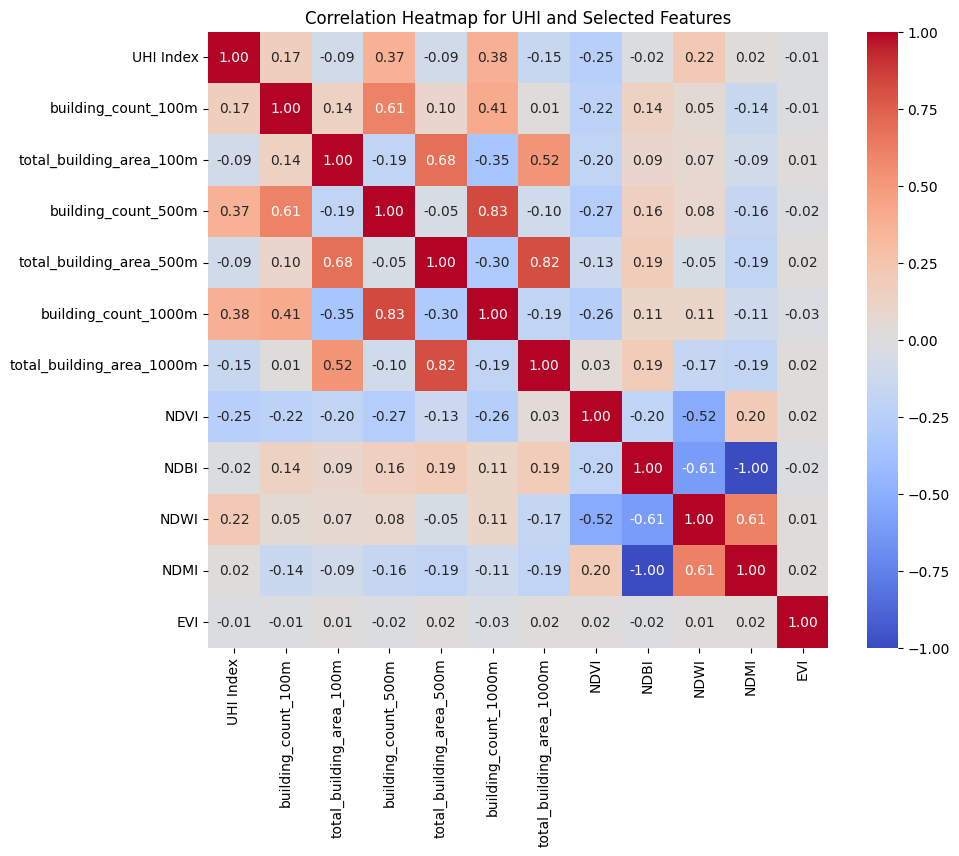

In [82]:
# Correlation Heatmap
# list of features of interest, including the UHI Index and other numeric features.
features = [
    'UHI Index', 'building_count_100m', 'total_building_area_100m',
    'building_count_500m', 'total_building_area_500m', 'building_count_1000m',
    'total_building_area_1000m', 'NDVI', 'NDBI', 'NDWI', 'NDMI', 'EVI'
]

# Compute the correlation matrix
corr_matrix = uhi_data[features].corr()

# Plot the correlation matrix as a heatmap.
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap for UHI and Selected Features')
plt.show()

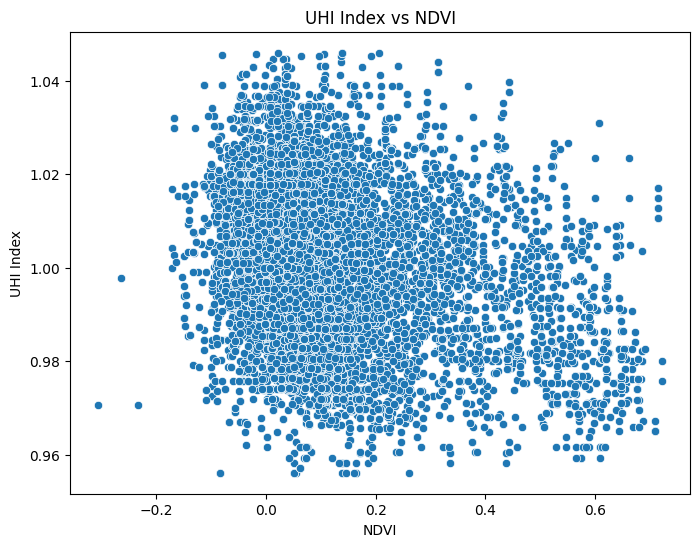

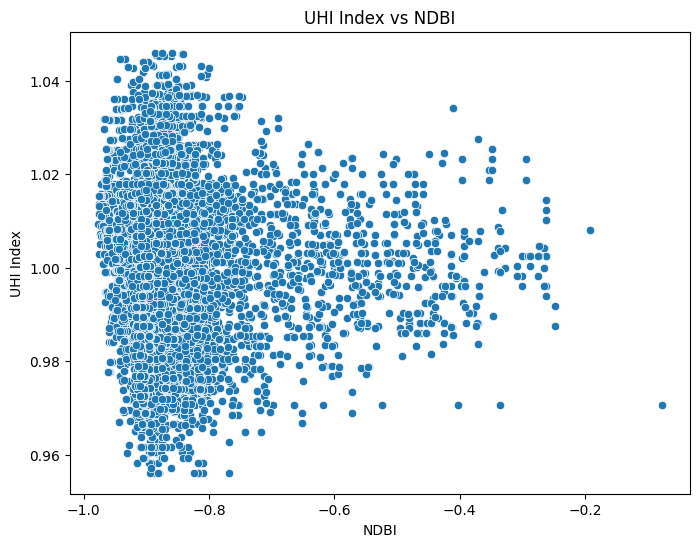

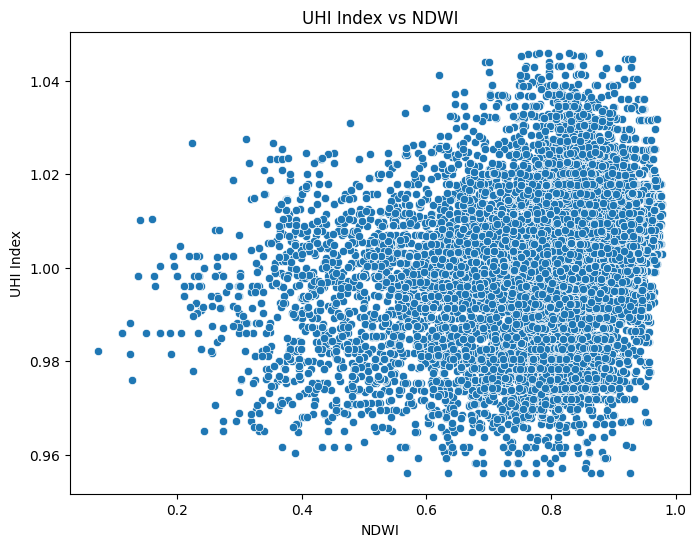

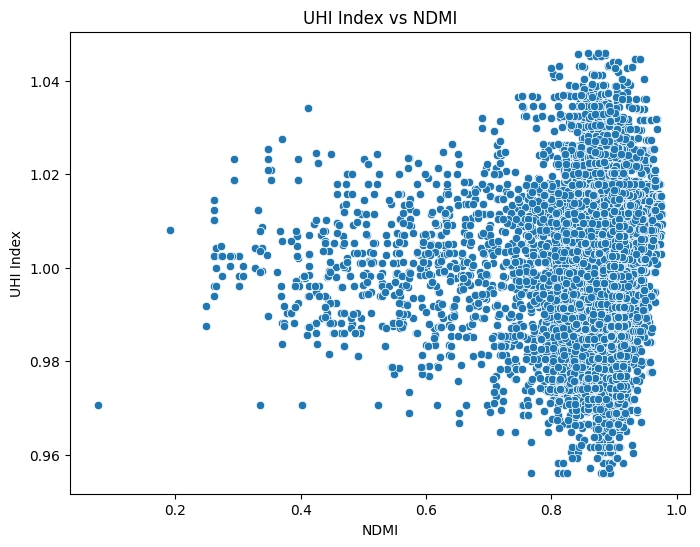

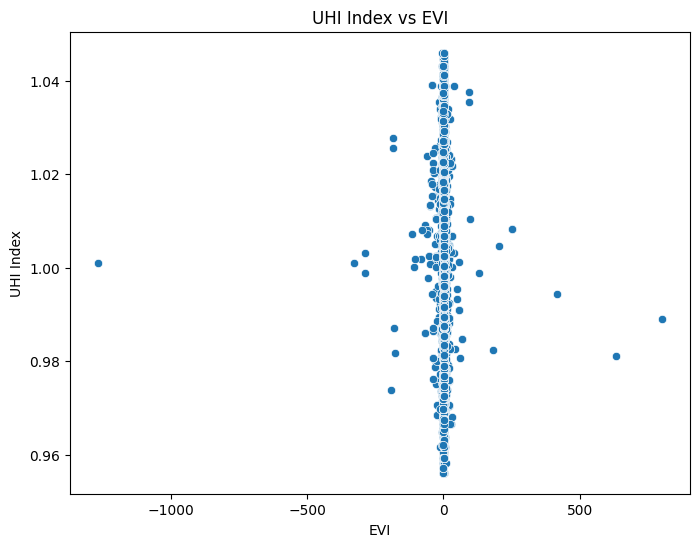

In [83]:
# List of satellite indices to plot against UHI Index.
indices = ['NDVI', 'NDBI', 'NDWI', 'NDMI', 'EVI']

# Loop through each index and generate a scatter plot.
for idx in indices:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=idx, y='UHI Index', data=uhi_data)
    plt.title(f'UHI Index vs {idx}')
    plt.xlabel(idx)
    plt.ylabel('UHI Index')
    plt.show()


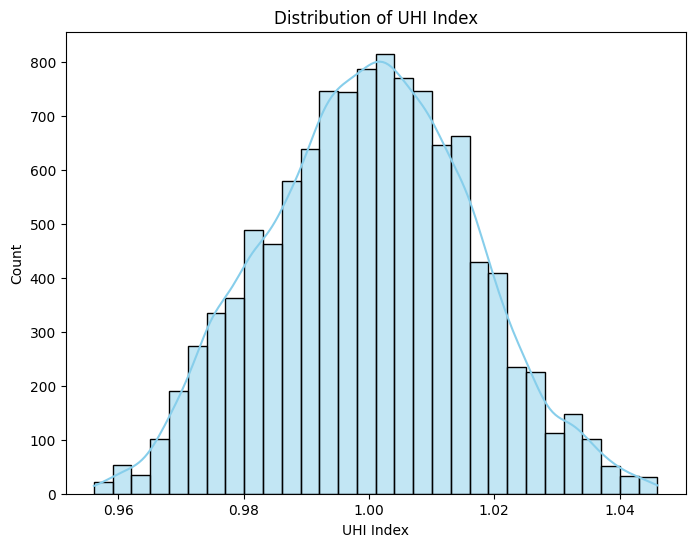

In [84]:
# Distribution of UHI Index
plt.figure(figsize=(8, 6))
sns.histplot(uhi_data['UHI Index'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of UHI Index')
plt.xlabel('UHI Index')
plt.ylabel('Count')
plt.show()

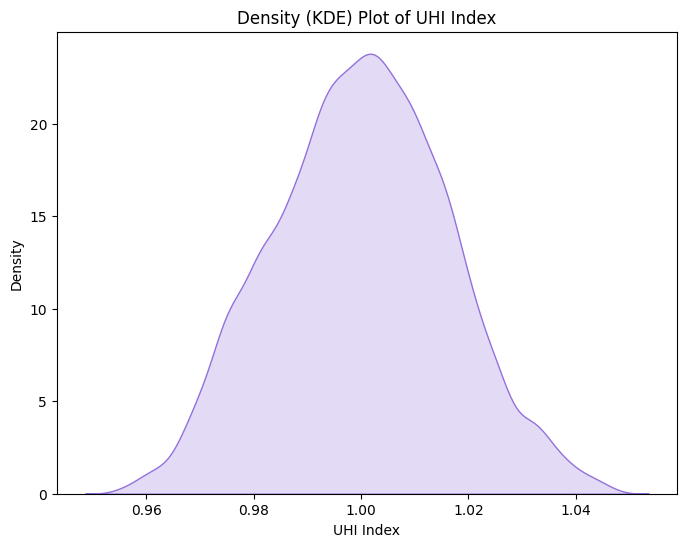

In [85]:
# density (KDE) plot for the UHI Index
plt.figure(figsize=(8, 6))
sns.kdeplot(uhi_data['UHI Index'], shade=True, color='mediumpurple')
plt.title('Density (KDE) Plot of UHI Index')
plt.xlabel('UHI Index')
plt.ylabel('Density')
plt.show()

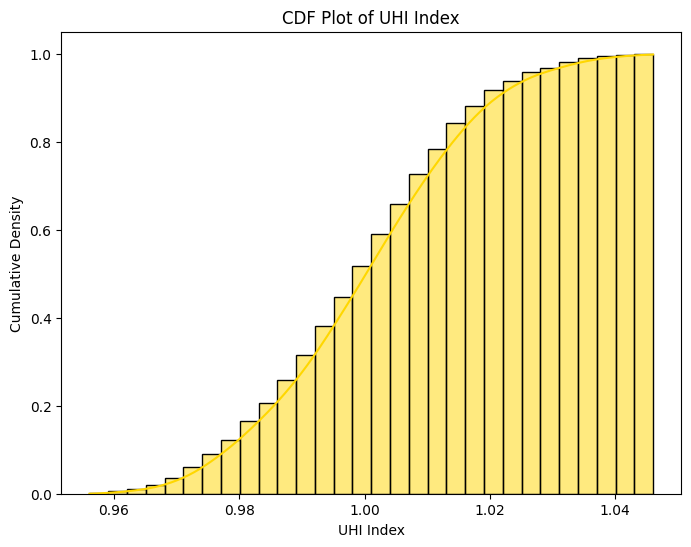

In [86]:
# cumulative probability distribution of the UHI Index
plt.figure(figsize=(8, 6))
sns.histplot(uhi_data['UHI Index'], bins=30, cumulative=True, stat='density', color='gold', kde=True)
plt.title('CDF Plot of UHI Index')
plt.xlabel('UHI Index')
plt.ylabel('Cumulative Density')
plt.show()

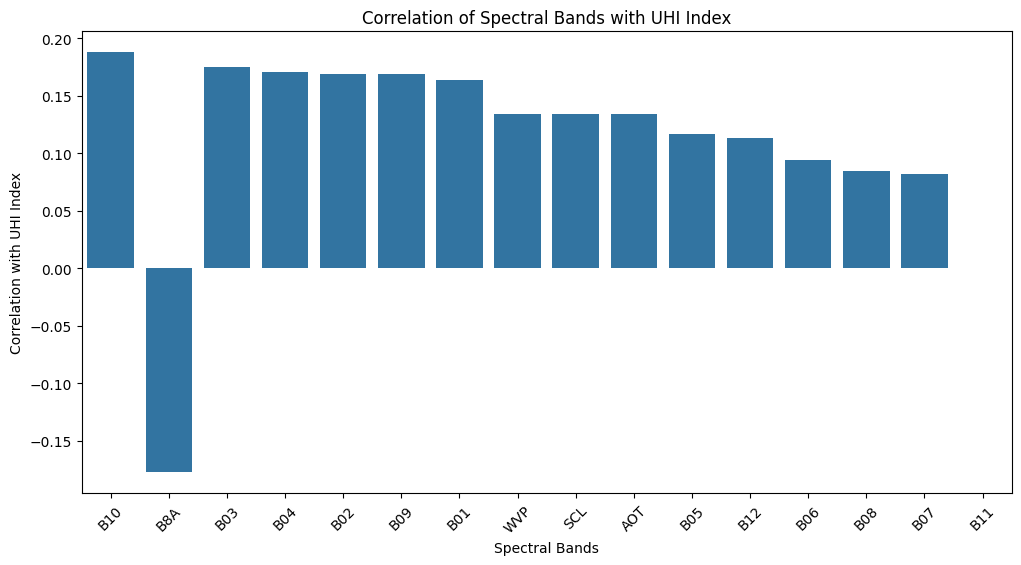

In [87]:
# Define a list of spectral bands and related features.
band_features = [
    'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07',
    'B08', 'B09', 'B10', 'B11', 'B12', 'B8A', 'AOT', 'WVP', 'SCL'
]

# Calculate correlation of each band feature with the UHI Index.
correlations = {feature: uhi_data['UHI Index'].corr(uhi_data[feature]) for feature in band_features}

# Convert the correlation dictionary to a DataFrame for better visualization.
corr_df = pd.DataFrame(list(correlations.items()), columns=['Feature', 'Correlation'])

# Sort the DataFrame based on the absolute value of the correlation coefficient.
corr_df = corr_df.sort_values('Correlation', key=lambda x: abs(x), ascending=False)

# Plot a bar chart to visualize the correlations.
plt.figure(figsize=(12, 6))
sns.barplot(x='Feature', y='Correlation', data=corr_df)
plt.title('Correlation of Spectral Bands with UHI Index')
plt.xlabel('Spectral Bands')
plt.ylabel('Correlation with UHI Index')
plt.xticks(rotation=45)
plt.show()


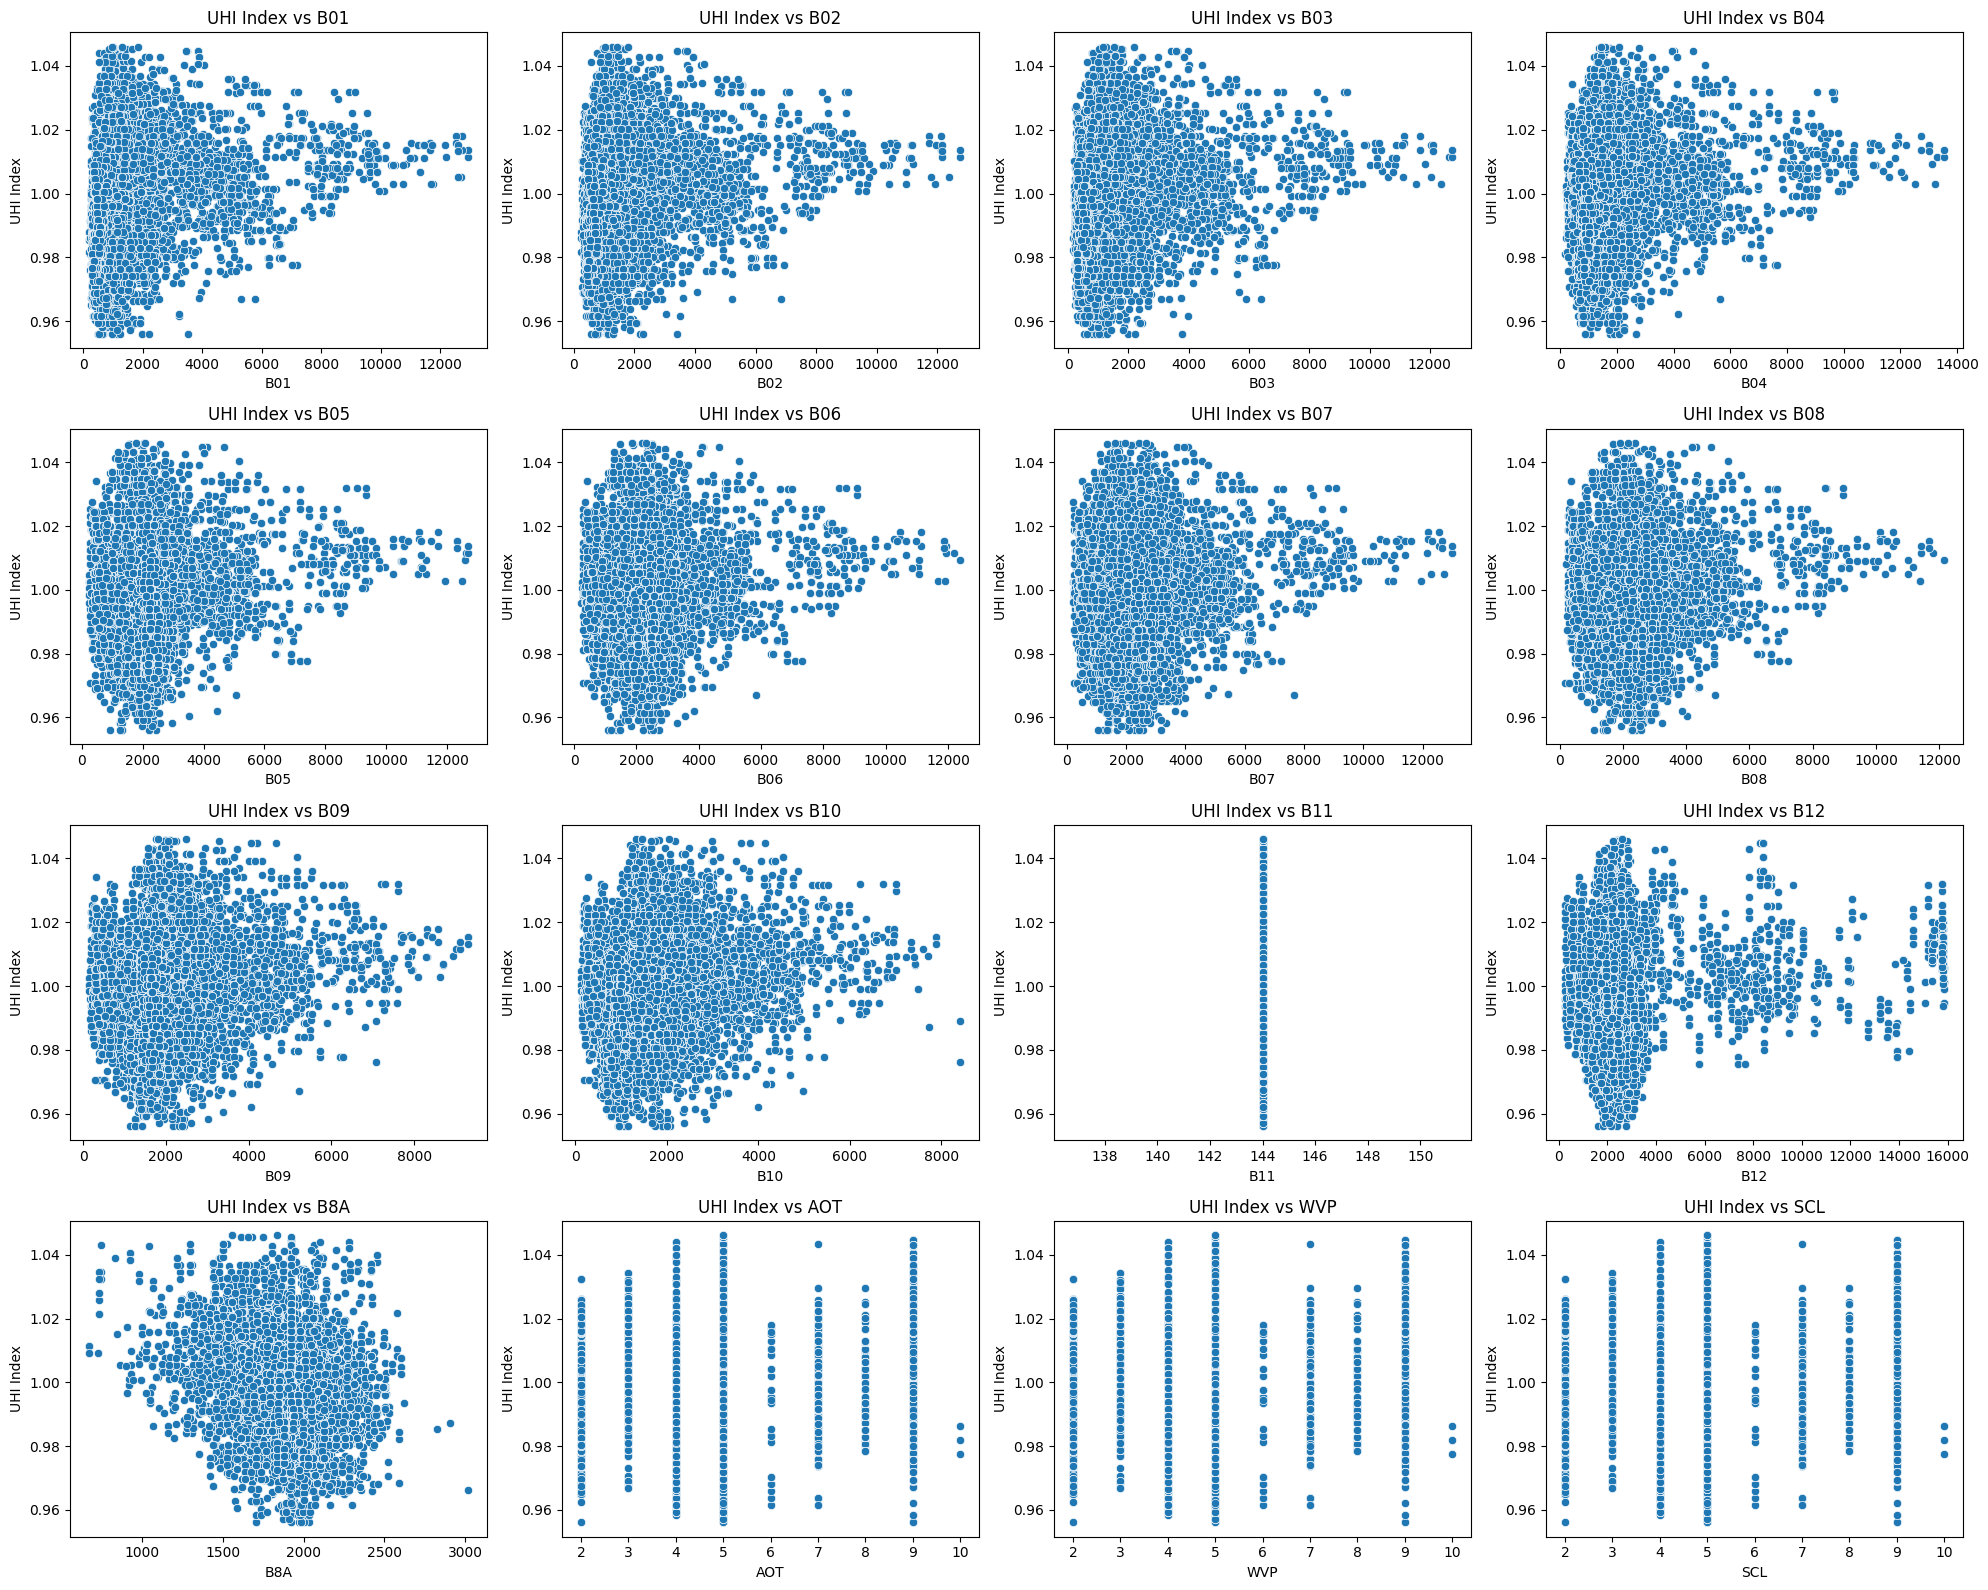

In [88]:
import math

# Number of features to plot
num_features = len(band_features)
# Determine grid dimensions (e.g., 4 columns)
cols = 4
rows = math.ceil(num_features / cols)

# Create subplots
fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axs = axs.flatten()

# Loop over each feature and plot a scatter plot vs. UHI Index.
for i, feature in enumerate(band_features):
    sns.scatterplot(x=feature, y='UHI Index', data=uhi_data, ax=axs[i])
    axs[i].set_title(f'UHI Index vs {feature}')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('UHI Index')

# Remove any empty subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


### Removing duplicates

Duplicate entries based on selected columns are removed. This process ensures that the dataset remains free of redundancy, preventing bias and skew caused by repeated data, and allowing the model to train on unique and relevant observations.

In [89]:
import numpy as np

# Define the columns to check for duplicates.
columns_to_check = [
    'Longitude', 'Latitude', 'UHI Index', 'building_count_100m', 'total_building_area_100m', 'building_count_500m',
    'total_building_area_500m', 'building_count_1000m', 'total_building_area_1000m', 'area_rural', 'area_urban',
    'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B10', 'B11', 'B12', 'B8A', 'AOT', 'WVP', 'SCL',
    'NDVI', 'NDBI', 'NDWI', 'NDMI', 'EVI'
]

# For each column in the specified list, check if the value is a numpy array with more than one dimension.
for col in columns_to_check:
    uhi_data[col] = uhi_data[col].apply(lambda x: tuple(x) if isinstance(x, np.ndarray) and x.ndim > 0 else x)

# Remove duplicate rows based on the specified columns, keeping only the first occurrence.
uhi_data = uhi_data.drop_duplicates(subset=columns_to_check, keep='first')

# Display information about the training dataset after duplicate removal.
print("Training Data after removing duplicates:")
uhi_data.info()

Training Data after removing duplicates:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11229 entries, 0 to 11228
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Longitude                  11229 non-null  float64       
 1   Latitude                   11229 non-null  float64       
 2   datetime                   11229 non-null  datetime64[ns]
 3   UHI Index                  11229 non-null  float64       
 4   building_count_100m        11229 non-null  int64         
 5   total_building_area_100m   11229 non-null  float64       
 6   building_count_500m        11229 non-null  int64         
 7   total_building_area_500m   11229 non-null  float64       
 8   building_count_1000m       11229 non-null  int64         
 9   total_building_area_1000m  11229 non-null  float64       
 10  area_rural                 11229 non-null  bool          
 11  area_urban                

In [90]:
# for Validation Data (uhi_validation_data)
for col in columns_to_check:
    if col in uhi_validation_data.columns:
        uhi_validation_data[col] = uhi_validation_data[col].apply(lambda x: tuple(x) if isinstance(x, np.ndarray) and x.ndim > 0 else x)

# Remove duplicate rows from the validation data using the same subset of columns.
uhi_validation_data = uhi_validation_data.drop_duplicates(subset=columns_to_check, keep='first')

# Display information about the validation dataset after duplicate removal.
print("\nValidation Data after removing duplicates:")
uhi_validation_data.info()



Validation Data after removing duplicates:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040 entries, 0 to 1039
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Longitude                  1040 non-null   float64
 1   Latitude                   1040 non-null   float64
 2   UHI Index                  0 non-null      float64
 3   building_count_100m        1040 non-null   int64  
 4   total_building_area_100m   1040 non-null   float64
 5   building_count_500m        1040 non-null   int64  
 6   total_building_area_500m   1040 non-null   float64
 7   building_count_1000m       1040 non-null   int64  
 8   total_building_area_1000m  1040 non-null   float64
 9   area_rural                 1040 non-null   bool   
 10  area_urban                 1040 non-null   bool   
 11  B01                        1040 non-null   float64
 12  B02                        1040 non-null   float64
 13  B03 

In [91]:
uhi_data.head()

,Longitude,Latitude,datetime,UHI Index,building_count_100m,total_building_area_100m,building_count_500m,total_building_area_500m,building_count_1000m,total_building_area_1000m,...,B12,B8A,AOT,WVP,SCL,NDVI,NDBI,NDWI,NDMI,EVI
0,-73.909167,40.813107,2021-07-24 15:53:00,1.030289,9,22021.913865,173,238056.221827,722,990085.767678,...,2096.0,1924.0,5.0,5.0,5,0.125773,-0.838384,0.755932,0.838384,0.609594
1,-73.909187,40.813045,2021-07-24 15:53:00,1.030289,10,23529.583653,174,242292.709280,720,994295.954553,...,2096.0,1924.0,5.0,5.0,5,0.125773,-0.838384,0.755932,0.838384,0.609594
2,-73.909215,40.812978,2021-07-24 15:53:00,1.023798,9,21067.543693,177,247121.188061,718,990577.919305,...,2096.0,2068.0,5.0,5.0,5,0.341867,-0.874400,0.662368,0.874400,1.170372
3,-73.909242,40.812908,2021-07-24 15:53:00,1.023798,8,19166.747335,175,246855.836543,716,990771.620217,...,2096.0,2068.0,5.0,5.0,5,0.341867,-0.874400,0.640449,0.874400,0.919704
4,-73.909257,40.812845,2021-07-24 15:53:00,1.021634,8,19166.747335,173,245431.994656,709,985447.972126,...,2096.0,1924.0,5.0,5.0,5,0.336367,-0.869091,0.676040,0.869091,0.994045


In [92]:
# Reset the index of the training dataset, dropping the old index.
uhi_data = uhi_data.reset_index(drop=True)
print("Training data index has been reset:")
print(uhi_data.head())

# Reset the index of the validation dataset, dropping the old index.
uhi_validation_data = uhi_validation_data.reset_index(drop=True)
print("\nValidation data index has been reset:")
print(uhi_validation_data.head())


Training data index has been reset:
   Longitude   Latitude            datetime  UHI Index  building_count_100m  \
0 -73.909167  40.813107 2021-07-24 15:53:00   1.030289                    9   
1 -73.909187  40.813045 2021-07-24 15:53:00   1.030289                   10   
2 -73.909215  40.812978 2021-07-24 15:53:00   1.023798                    9   
3 -73.909242  40.812908 2021-07-24 15:53:00   1.023798                    8   
4 -73.909257  40.812845 2021-07-24 15:53:00   1.021634                    8   

   total_building_area_100m  building_count_500m  total_building_area_500m  \
0              22021.913865                  173             238056.221827   
1              23529.583653                  174             242292.709280   
2              21067.543693                  177             247121.188061   
3              19166.747335                  175             246855.836543   
4              19166.747335                  173             245431.994656   

   building_count_10

### Model Building

Now, let us select the columns required for our model building. We will retain key predictor variables that we believe influence the UHI index. These include built environment features (like building counts and total building areas at various scales), area classifications (urban versus rural), multiple spectral bands from the Sentinel-2 data (B01 through B12, including B8A), and derived indices (NDVI, NDBI, NDWI, NDMI, and EVI). Notice that we are excluding latitude and longitude, as geographic coordinates do not directly contribute to predicting the UHI index.

In [93]:
# Define the list of columns to retain.
retain_cols = [
    'UHI Index', 'building_count_100m', 'total_building_area_100m',
    'building_count_500m', 'total_building_area_500m',
    'building_count_1000m', 'total_building_area_1000m', 'area_rural',
    'area_urban', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08',
    'B09', 'B10', 'B12', 'B8A', 'NDVI', 'NDBI', 'NDWI', 'NDMI'
]

# For Training Data:
uhi_data = uhi_data[retain_cols]
print("Training data after retaining specific columns:")
print(uhi_data.info())


Training data after retaining specific columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11229 entries, 0 to 11228
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   UHI Index                  11229 non-null  float64
 1   building_count_100m        11229 non-null  int64  
 2   total_building_area_100m   11229 non-null  float64
 3   building_count_500m        11229 non-null  int64  
 4   total_building_area_500m   11229 non-null  float64
 5   building_count_1000m       11229 non-null  int64  
 6   total_building_area_1000m  11229 non-null  float64
 7   area_rural                 11229 non-null  bool   
 8   area_urban                 11229 non-null  bool   
 9   B01                        11229 non-null  float64
 10  B02                        11229 non-null  float64
 11  B03                        11229 non-null  float64
 12  B04                        11229 non-null  float64
 13

In [94]:
# Define the list of columns to retain.
retain_col = [
    'Longitude', 'Latitude', 'UHI Index', 'building_count_100m', 'total_building_area_100m',
    'building_count_500m', 'total_building_area_500m',
    'building_count_1000m', 'total_building_area_1000m', 'area_rural',
    'area_urban', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08',
    'B09', 'B10', 'B12', 'B8A', 'NDVI', 'NDBI', 'NDWI', 'NDMI'
]

# For Validation Data:
uhi_validation_data = uhi_validation_data[retain_col]
print("\nValidation data after retaining specific columns:")
print(uhi_validation_data.info())



Validation data after retaining specific columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040 entries, 0 to 1039
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Longitude                  1040 non-null   float64
 1   Latitude                   1040 non-null   float64
 2   UHI Index                  0 non-null      float64
 3   building_count_100m        1040 non-null   int64  
 4   total_building_area_100m   1040 non-null   float64
 5   building_count_500m        1040 non-null   int64  
 6   total_building_area_500m   1040 non-null   float64
 7   building_count_1000m       1040 non-null   int64  
 8   total_building_area_1000m  1040 non-null   float64
 9   area_rural                 1040 non-null   bool   
 10  area_urban                 1040 non-null   bool   
 11  B01                        1040 non-null   float64
 12  B02                        1040 non-null   float64
 1

#### Train and Test Split

In [95]:
# Split the data into features (X) and target (y), and then into training and testing sets
X = uhi_data.drop(columns=['UHI Index']).values
y = uhi_data ['UHI Index'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

#### Feature Scaling

In [96]:
# Scale the training and test data using standardscaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#### Model Training

In [97]:
# Train the Random Forest model on the training data
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train,y_train)

RandomForestRegressor(random_state=42)

#### Model Evaluation

#### In-Sample Evaluation

In [98]:
# Make predictions on the training data
insample_predictions = model.predict(X_train)

In [99]:
# calculate R-squared score for in-sample predictions
Y_train = y_train.tolist()
r2_score(Y_train, insample_predictions)

0.9879151209123659

#### Out-Sample Evaluation

In [100]:
# Make predictions on the test data
outsample_predictions = model.predict(X_test)

In [101]:
# calculate R-squared score for out-sample predictions
Y_test = y_test.tolist()
r2_score(Y_test, outsample_predictions)

0.9178507574151765

In [102]:
# Predict on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

# Display the metrics
print("R² Score:", r2)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)

R² Score: 0.9178507574151765
Mean Squared Error (MSE): 2.1701981839391353e-05
Root Mean Squared Error (RMSE): 0.00465853859481612
Mean Absolute Error (MAE): 0.003262456767548049


#### Model Evaluation Using Cross-Validation
This will performs 5-fold cross-validation on the model using multiple scoring metrics: R², MSE, and MAE. The MSE and MAE scores are returned as negative values due to scikit-learn's convention for error metrics. By taking the negative of these values, you obtain the conventional positive error metrics. The code then prints the cross-validated performance metrics, helping assess the model’s predictive accuracy and error.

In [103]:
from sklearn.model_selection import cross_validate

scoring = {
    'r2': 'r2',
    'mse': 'neg_mean_squared_error',
    'mae': 'neg_mean_absolute_error'
}

cv_results = cross_validate(model, X, y, cv=5, scoring=scoring, return_train_score=True)

print("Cross-validated R² scores:", cv_results['test_r2'])
print("Mean R² score:", np.mean(cv_results['test_r2']))
print("Cross-validated MSE scores:", -cv_results['test_mse'])  # negative values
print("Cross-validated MAE scores:", -cv_results['test_mae'])  # negative values


Cross-validated R² scores: [ 0.13265602 -0.19488215 -0.03937434 -0.4723515  -0.19656901]
Mean R² score: -0.15410419555547622
Cross-validated MSE scores: [0.00027368 0.00020299 0.00026514 0.00025429 0.00026303]
Cross-validated MAE scores: [0.01293421 0.0115125  0.01388395 0.01287824 0.01294616]


#### Model Performance Evaluation

- **Out-of-Sample Results:**  
  The model (without tuning) achieved excellent results on the test set (R² ≈ 0.917, very low MSE, RMSE, and MAE).

- **Cross-Validation Results:**  
  In contrast, cross-validation showed much poorer performance (negative R² and higher errors), indicating unstable performance across different data splits.

- **Takeaway:**  
  These differences highlight the need for proper tuning and consistent evaluation methods to ensure the model generalizes well to unseen data.een data.

### Hyperparameter Tuning

This section outl r approach to tuning model hyperparameters. Even though our out-of-sample results look promising, our cross-validation indicates unstable performance. Fine-tuning the hyperparameters will help improve the model’s consistency and ensure it generalizes well across different data splits.

#### Building a ML Pipeline
Building a pipeline that first scales the features using MinMaxScaler and then fits a Gradient Boosting Regressor for prediction.

In [104]:
# Build a pipeline that includes scaling and the Gradient Boosting Regressor
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('gbr', GradientBoostingRegressor(random_state=42))
])

#### Hyperparameter Tuning Grid
Defining a parameter grid for tuning the Gradient Boosting Regressor within our pipeline. It specifies various hyperparameter options—including learning rate, number of estimators, maximum depth, subsample ratio, and minimum samples for split—to explore during grid search and find the optimal model configuration.

In [105]:
# parameter grid for tuning
param_grid = {
    'gbr__learning_rate': [0.05, 0.1],
    'gbr__n_estimators': [100, 200],
    'gbr__max_depth': [3, 5],
    'gbr__subsample': [0.8, 1.0],
    'gbr__min_samples_split': [5, 10]
}

### Hyperparameter Tuning with GridSearchCVSetting  up a grid search with 5-fold cross-validation to tune the hyperparameters or pipeline using negative MSE as the evaluation metric. It then fits the grid search on the training data to find the best parameter combination for our model.

In [106]:
# Set up GridSearchCV with 5-fold cross-validation using negative MSE as scoring metric
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=3
)

# Fit the grid search on the training data
grid_search.fit(X_train, y_train)



Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('gbr',
                                        GradientBoostingRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'gbr__learning_rate': [0.05, 0.1],
                         'gbr__max_depth': [3, 5],
                         'gbr__min_samples_split': [5, 10],
                         'gbr__n_estimators': [100, 200],
                         'gbr__subsample': [0.8, 1.0]},
             scoring='neg_mean_squared_error', verbose=3)

In [107]:
# Output the best hyperparameters and corresponding CV score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best CV MSE:", -grid_search.best_score_)

# Evaluate the tuned model on the test set
best_model = grid_search.best_estimator_
test_r2 = best_model.score(X_test, y_test)
print("Test R² Score:", test_r2)


Best Hyperparameters: {'gbr__learning_rate': 0.1, 'gbr__max_depth': 5, 'gbr__min_samples_split': 5, 'gbr__n_estimators': 200, 'gbr__subsample': 0.8}
Best CV MSE: 4.019635451508968e-05
Test R² Score: 0.8570640626830345


#### Random Forest Regressor

In [109]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

# Data Preparation
X = uhi_data.drop(columns=["UHI Index"])
y = uhi_data["UHI Index"]

# Convert boolean columns to integers if necessary
X["area_urban"] = X["area_urban"].astype(int)
X["area_rural"] = X["area_rural"].astype(int)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --------------------------
# Pipeline and Grid Search Setup for Random Forest
# --------------------------
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', RandomForestRegressor(random_state=42))
])

param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 5, 10],
    'model__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit grid search on training data
grid_search.fit(X_train, y_train)

# Retrieve best model and make predictions on the test set
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)

# --------------------------
# Evaluation
# --------------------------
print("Random Forest")
print("Best Hyperparameters:", grid_search.best_params_)
print("Best CV MSE:", -grid_search.best_score_)
print("Test R² Score:", r2_score(y_test, y_pred))
print("Test MSE:", mean_squared_error(y_test, y_pred))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test MAE:", mean_absolute_error(y_test, y_pred))


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Random Forest
Best Hyperparameters: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 300}
Best CV MSE: 2.3142131921457475e-05
Test R² Score: 0.9254752257864892
Test MSE: 1.9592526967523645e-05
Test RMSE: 0.004426344650783945
Test MAE: 0.003050001806862211


#### XGBoost

In [111]:
from xgboost import XGBRegressor

# Data Preparation
X = uhi_data.drop(columns=["UHI Index"])
y = uhi_data["UHI Index"]

# Convert boolean columns to integers if necessary
X["area_urban"] = X["area_urban"].astype(int)
X["area_rural"] = X["area_rural"].astype(int)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --------------------------
# Pipeline and Grid Search Setup for XGBoost
# --------------------------
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', XGBRegressor(random_state=42, verbosity=0))
])

param_grid = {
    'model__learning_rate': [0.01, 0.1],
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7],
    'model__subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit grid search on training data
grid_search.fit(X_train, y_train)

# Retrieve best model and make predictions on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# --------------------------
# Evaluation
# --------------------------
print("XGBoost")
print("Best Hyperparameters:", grid_search.best_params_)
print("Best CV MSE:", -grid_search.best_score_)
print("Test R² Score:", r2_score(y_test, y_pred))
print("Test MSE:", mean_squared_error(y_test, y_pred))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test MAE:", mean_absolute_error(y_test, y_pred))


Fitting 5 folds for each of 36 candidates, totalling 180 fits
XGBoost
Best Hyperparameters: {'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 300, 'model__subsample': 0.8}
Best CV MSE: 2.1951562196547386e-05
Test R² Score: 0.9263321835155703
Test MSE: 1.936723319650265e-05
Test RMSE: 0.00440082187738866
Test MAE: 0.003192270558255745


#### ExtraTrees Regressor

In [112]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# scoring metrics: R², negative MSE, and negative MAE.
scoring = {
    'r2': 'r2',
    'mse': 'neg_mean_squared_error',
    'mae': 'neg_mean_absolute_error'
}

# Build a pipeline for Extra Trees with data scaling.
pipeline_et = Pipeline([
    ('scaler', MinMaxScaler()),
    ('et', ExtraTreesRegressor(random_state=42))
])

# Parameter grid for tuning Extra Trees.
param_grid_et = {
    'et__n_estimators': [100, 200],
    'et__max_depth': [None, 10, 20],
    'et__min_samples_split': [2, 5, 10]
}

# Set up GridSearchCV for Extra Trees.
grid_search_et = GridSearchCV(
    estimator=pipeline_et,
    param_grid=param_grid_et,
    cv=5,
    scoring=scoring,
    refit='mse',       # Refit on the model with the best (lowest) MSE.
    n_jobs=-1,
    verbose=3,
    return_train_score=True
)

# Fit grid search on the training data.
grid_search_et.fit(X_train, y_train)

# Print the best hyperparameters and the best cross-validated MSE.
print("Best Hyperparameters (Extra Trees):", grid_search_et.best_params_)
print("Best CV MSE (Extra Trees):", -grid_search_et.best_score_)

# Retrieve cross-validation results
cv_results = grid_search_et.cv_results_
mean_r2 = cv_results['mean_test_r2'][grid_search_et.best_index_]
mean_mae = -cv_results['mean_test_mae'][grid_search_et.best_index_]

# Evaluate the best model on the test set
best_model_et = grid_search_et.best_estimator_
y_pred = best_model_et.predict(X_test)

# Compute test metrics
test_r2 = r2_score(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred)

print("Test R² Score (Extra Trees):", test_r2)
print("Test MSE (Extra Trees):", test_mse)
print("Test RMSE (Extra Trees):", test_rmse)
print("Test MAE (Extra Trees):", test_mae)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Hyperparameters (Extra Trees): {'et__max_depth': None, 'et__min_samples_split': 2, 'et__n_estimators': 200}
Best CV MSE (Extra Trees): 1.8229980268278023e-05
Test R² Score (Extra Trees): 0.9425177172058139
Test MSE (Extra Trees): 1.5112064245553063e-05
Test RMSE (Extra Trees): 0.003887423857203259
Test MAE (Extra Trees): 0.0026103578576910907


#### Submission File UHI Prediction

In [113]:
# Loading validation data
submission = uhi_validation_data

# Display the columns to verify they match the training features
print("Submission columns:", submission.columns)
print("training columns:", uhi_data.columns)

Submission columns: Index(['Longitude', 'Latitude', 'UHI Index', 'building_count_100m',
       'total_building_area_100m', 'building_count_500m',
       'total_building_area_500m', 'building_count_1000m',
       'total_building_area_1000m', 'area_rural', 'area_urban', 'B01', 'B02',
       'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B10', 'B12', 'B8A',
       'NDVI', 'NDBI', 'NDWI', 'NDMI'],
      dtype='object')
training columns: Index(['UHI Index', 'building_count_100m', 'total_building_area_100m',
       'building_count_500m', 'total_building_area_500m',
       'building_count_1000m', 'total_building_area_1000m', 'area_rural',
       'area_urban', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08',
       'B09', 'B10', 'B12', 'B8A', 'NDVI', 'NDBI', 'NDWI', 'NDMI'],
      dtype='object')


In [114]:
# List of training features (excluding the target 'UHI Index')
train_features = ['building_count_100m', 'total_building_area_100m',
       'building_count_500m', 'total_building_area_500m',
       'building_count_1000m', 'total_building_area_1000m', 'area_rural',
       'area_urban', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08',
       'B09', 'B10', 'B12', 'B8A', 'NDVI', 'NDBI', 'NDWI', 'NDMI']

# For instance, drop 'Longitude', 'Latitude', and the 'UHI Index'
X_submission = submission.drop(columns=["UHI Index"])

# Reorder the columns to match training features
X_submission = X_submission.reindex(columns=train_features)

print("Adjusted submission columns:", X_submission.columns)

Adjusted submission columns: Index(['building_count_100m', 'total_building_area_100m',
       'building_count_500m', 'total_building_area_500m',
       'building_count_1000m', 'total_building_area_1000m', 'area_rural',
       'area_urban', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08',
       'B09', 'B10', 'B12', 'B8A', 'NDVI', 'NDBI', 'NDWI', 'NDMI'],
      dtype='object')


In [115]:
# Create a copy of the submission DataFrame for each model to avoid overwriting
submission_rf = submission.copy()
submission_xgb = submission.copy()
submission_et = submission.copy()

# Make Predictions using Random Forest
submission_rf["UHI Index"] = best_rf_model.predict(X_submission)
submission_rf[['Latitude', 'Longitude', 'UHI Index']].to_csv('submission_randomforest.csv', index=False)

# Make Predictions using XGBoost
submission_xgb["UHI Index"] = best_model.predict(X_submission)  # Rename variable if needed (e.g., best_xgb_model)
submission_xgb[['Latitude', 'Longitude', 'UHI Index']].to_csv('submission_xgboost.csv', index=False)

# Make Predictions using Extra Trees
submission_et["UHI Index"] = best_model_et.predict(X_submission)
submission_et[['Latitude', 'Longitude', 'UHI Index']].to_csv('submission_extratrees.csv', index=False)

print('All files saved successfully!')

All files saved successfully!
